In [1]:
!pip install geopy networkx
!pip install matplotlib seaborn
!pip install transformers langchain
!pip install accelerate
!pip install sqlite-utils
!pip install rich
!pip install folium
!pip install bitsandbytes
!pip install shapely geopandas
!pip install geodatasets

In [2]:
import random
import math
import time
import sqlite3
from datetime import datetime
import transformers
from collections import defaultdict
from geopy.distance import geodesic
from geopy.point import Point
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import logging
import uuid
import warnings
import folium
from geopy.distance import geodesic
from folium.plugins import HeatMap
import uuid
from datetime import datetime, timedelta
from geopy.geocoders import Nominatim
import time
import geopandas as gpd
from shapely.geometry import Point
from geodatasets import get_path
import re
import sqlite3
from transformers import AutoModelForSeq2SeqLM, pipeline
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import torch
from transformers import BitsAndBytesConfig
from folium import PolyLine

In [3]:
nyc_center = (40.7549, -73.9840)
nyc_map = folium.Map(location=nyc_center, zoom_start=11, tiles='cartodbpositron')

In [4]:
nyc_map

In [5]:
warehouses = {
    "A (Manhattan)": (40.7549, -73.9840),
    "B (Deep South Brooklyn)": (40.5800, -73.9700),  
    "C (Deep Queens)": (40.7500, -73.7200),          
    "D (Upper Bronx)": (40.9050, -73.8500),
    "E (Staten Island)": (40.5795, -74.1502),
}

In [6]:
def validate_distances(warehouses, min_miles=10):
    keys = list(warehouses.keys())
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            loc1 = warehouses[keys[i]]
            loc2 = warehouses[keys[j]]
            dist = geodesic(loc1, loc2).miles
            if dist < min_miles:
                print(f"{keys[i]} and {keys[j]} are only {dist:.2f} miles apart!")
            else:
                print(f"{keys[i]} and {keys[j]}: {dist:.2f} miles")
validate_distances(warehouses)

A (Manhattan) and B (Deep South Brooklyn): 12.09 miles
A (Manhattan) and C (Deep Queens): 13.86 miles
A (Manhattan) and D (Upper Bronx): 12.51 miles
A (Manhattan) and E (Staten Island): 14.92 miles
B (Deep South Brooklyn) and C (Deep Queens): 17.61 miles
B (Deep South Brooklyn) and D (Upper Bronx): 23.29 miles
B (Deep South Brooklyn) and E (Staten Island) are only 9.48 miles apart!
C (Deep Queens) and D (Upper Bronx): 12.68 miles
C (Deep Queens) and E (Staten Island): 25.48 miles
D (Upper Bronx) and E (Staten Island): 27.44 miles


In [7]:
nyc_map = folium.Map(location=nyc_center, zoom_start=10, tiles="cartodbpositron")
for name, coord in warehouses.items():
    folium.Marker(
        location=coord,
        popup=name,
        icon=folium.Icon(color='blue', icon='home', prefix='fa')
    ).add_to(nyc_map)
for i, (name1, coord1) in enumerate(warehouses.items()):
    for j, (name2, coord2) in enumerate(warehouses.items()):
        if i < j:
            folium.PolyLine([coord1, coord2], color="gray", weight=1, opacity=0.5).add_to(nyc_map)

In [8]:
nyc_map

In [9]:
dummy_deliveries = [(random.uniform(40.55, 40.90), random.uniform(-74.25, -73.70)) for _ in range(200)]
HeatMap(dummy_deliveries).add_to(nyc_map)

In [10]:
nyc_map

In [11]:
def generate_drones(warehouses, drones_per_hub=50):
    drones = {}
    for hub_code, (hub_name, coord) in zip("ABCDE", warehouses.items()):
        lat_base, lon_base = coord
        for i in range(1, drones_per_hub + 1):
            drone_id = f"{hub_code}{i}"
            jitter_lat = random.uniform(-0.005, 0.005)
            jitter_lon = random.uniform(-0.005, 0.005)
            drone_location = (lat_base + jitter_lat, lon_base + jitter_lon)
            is_faulty = random.random() < 0.10
            status = "maintenance" if is_faulty else "idle"
            battery = random.randint(5, 40) if is_faulty else random.randint(60, 100)
            drone_data = {
                "id": drone_id,
                "hub": hub_name,
                "location": drone_location,
                "battery": battery,
                "deliveries_completed": 0,
                "payload_capacity_kg": round(random.uniform(1.0, 5.0), 2),
                "last_maintenance": (
                    datetime.now() - timedelta(days=random.randint(0, 30))
                ).strftime("%Y-%m-%d"),
                "status": status
            }
            drones[drone_id] = drone_data  
    return drones
def plot_drones_map(drones, warehouses):
    nyc_map = folium.Map(location=nyc_center, zoom_start=11, tiles="cartodbpositron")
    for name, coord in warehouses.items():
        folium.Marker(
            location=coord,
            popup=name,
            icon=folium.Icon(color='blue', icon='home', prefix='fa')
        ).add_to(nyc_map)
    for drone in drones.values():
        color = 'red' if drone['status'] == 'maintenance' else 'green'
        folium.CircleMarker(
            location=drone['location'],
            radius=4,
            popup=f"{drone['id']} ({drone['battery']}%)",
            color=color,
            fill=True,
            fill_opacity=0.7
        ).add_to(nyc_map)
    return nyc_map
drones = generate_drones(warehouses)
print(f"Total drones: {len(drones)}")
nyc_map = plot_drones_map(drones, warehouses)

Total drones: 250


In [12]:
nyc_map

In [13]:
drones = generate_drones(warehouses)
print(f"Initialized {len(drones)} drones.")
print(next(iter(drones.values())))

Initialized 250 drones.
{'id': 'A1', 'hub': 'A (Manhattan)', 'location': (40.7517696393745, -73.98796672282454), 'battery': 61, 'deliveries_completed': 0, 'payload_capacity_kg': 3.97, 'last_maintenance': '2025-07-05', 'status': 'idle'}


In [14]:
path_to_file = get_path('nybb')
nyc_boroughs = gpd.read_file(path_to_file).to_crs(epsg=4326)
def get_land_point(lat_range, lon_range, boroughs):
    max_attempts = 100
    for _ in range(max_attempts):
        lat = round(random.uniform(*lat_range), 6)
        lon = round(random.uniform(*lon_range), 6)
        point = Point(lon, lat)
        if boroughs.contains(point).any():
            return (lat, lon)
    return None
def generate_deliveries_simulated(drones, boroughs):
    deliveries = []
    delivery_id = 1
    hub_bounds = {
        "A (Manhattan)":             ((40.7300, 40.7900), (-74.0100, -73.9350)),
        "B (Deep South Brooklyn)":   ((40.5700, 40.6200), (-74.0200, -73.9400)),
        "C (Deep Queens)":           ((40.7300, 40.7700), (-73.8200, -73.7000)),
        "D (Upper Bronx)":           ((40.8700, 40.9200), (-73.9200, -73.8300)),
        "E (Staten Island)":         ((40.5500, 40.6200), (-74.2100, -74.1000)),
    }
    for drone in drones.values():
        hub_name = drone["hub"]
        lat_range, lon_range = hub_bounds.get(hub_name, ((0, 0), (0, 0)))
        for _ in range(2):  
            location = get_land_point(lat_range, lon_range, boroughs)
            if not location:
                continue  
            lat, lon = location
            delivery = {
                "delivery_id": f"D{delivery_id:04}",
                "drone_id": drone["id"],
                "location": (lat, lon),
                "address": f"Simulated Address #{delivery_id}, {hub_name}",
                "payload_kg": round(random.uniform(0.5, 4.5), 2),
                "assigned_hub": hub_name,
                "status": "pending"
            }
            deliveries.append(delivery)
            delivery_id += 1
    return deliveries
deliveries = generate_deliveries_simulated(drones, nyc_boroughs)
print(f"Generated {len(deliveries)} safe, dry deliveries")
folium.map.CustomPane("labels").add_to(nyc_map)

Generated 500 safe, dry deliveries


In [15]:
def plot_drones_and_deliveries(drones, deliveries, warehouses):
    nyc_map = folium.Map(location=nyc_center, zoom_start=11, tiles="cartodbpositron")
    folium.map.CustomPane("deliveries").add_to(nyc_map)
    folium.map.CustomPane("drones").add_to(nyc_map)
    for name, coord in warehouses.items():
        folium.Marker(
            location=coord,
            popup=name,
            icon=folium.Icon(color='blue', icon='home', prefix='fa')
        ).add_to(nyc_map)
    for drone in drones.values():
        location = drone['location']
        color = 'red' if drone['status'] == 'maintenance' else 'green'
        popup = f"Drone {drone['id']}<br>Battery: {drone['battery']}%"
        folium.CircleMarker(
            location=location,
            radius=4,
            popup=popup,
            color=color,
            fill=True,
            fill_opacity=0.7,
            pane="drones"
        ).add_to(nyc_map)
    for delivery in deliveries:
        location = delivery['location']
        popup = f"Delivery {delivery['delivery_id']}<br>{delivery['payload_kg']} kg"
        folium.CircleMarker(
            location=location,
            radius=3,
            popup=popup,
            color='orange',
            fill=True,
            fill_opacity=0.6,
            pane="deliveries"
        ).add_to(nyc_map)
    return nyc_map
map_with_clean_deliveries = plot_drones_and_deliveries(drones, deliveries, warehouses)
map_with_clean_deliveries

In [16]:
def find_closest_warehouses(delivery_location, warehouses, top_n=3):
    """
    Given a delivery location, return a sorted list of warehouses
    from closest to farthest.
    """
    distances = []
    for name, location in warehouses.items():
        dist = geodesic(delivery_location, location).miles
        distances.append((name, dist))
    sorted_warehouses = sorted(distances, key=lambda x: x[1])
    return sorted_warehouses[:top_n]
sample_delivery = deliveries[0]
print(f"Delivery {sample_delivery['delivery_id']} at {sample_delivery['location']}")
closest_hubs = find_closest_warehouses(sample_delivery['location'], warehouses)
for i, (hub, miles) in enumerate(closest_hubs, start=1):
    print(f"  {i}. {hub} - {miles:.2f} miles")

Delivery D0001 at (40.785393, -73.943763)
  1. A (Manhattan) - 2.98 miles
  2. D (Upper Bronx) - 9.61 miles
  3. C (Deep Queens) - 11.99 miles


In [17]:
for delivery in deliveries:
    closest = find_closest_warehouses(delivery['location'], warehouses)
    delivery['closest_hubs'] = [hub for hub, _ in closest]

In [18]:
flan_model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(flan_model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(flan_model_name)

In [19]:
flan_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [20]:
def build_selection_prompt(delivery, candidate_drones):
    prompt = (
        f"Choose ONE drone ID from the list that is best for a delivery.\n"
        f"Delivery payload: {delivery['payload_kg']} kg\n"
        f"Delivery location: {delivery['location']}\n\n"
        f"Drones:\n"
    )
    for drone in candidate_drones:
        prompt += (
            f"{drone['id']}: Battery {drone['battery']}%, "
            f"Capacity {drone['payload_capacity_kg']} kg, Status {drone['status']}\n"
        )
    prompt += "\nAnswer ONLY with the ID (e.g., A4)."
    return prompt

In [21]:
def select_best_drone(delivery, drones, hub_name):
    candidates = [
        d for d in drones.values()
        if d['hub'] == hub_name and d['battery'] > 50 and
           d['payload_capacity_kg'] >= delivery['payload_kg'] and
           d['status'] == 'idle'
    ]
    print(f"Candidates found: {len(candidates)}")
    if not candidates:
        print(f"No suitable drones found for delivery {delivery['delivery_id']} from hub {hub_name}")
        print("Rejected drones:")
        for d in drones.values():
            if d['hub'] == hub_name and (
                d['battery'] <= 50 or
                d['payload_capacity_kg'] < delivery['payload_kg'] or
                d['status'] != 'idle'
            ):
                print(f"- {d['id']} | Battery: {d['battery']} | Capacity: {d['payload_capacity_kg']} | Status: {d['status']}")
        return None
    _ = flan_pipeline("What is 2 + 2?", max_length=10) 
    prompt = build_selection_prompt(delivery, candidates[:5])
    print("=== PROMPT ===")
    print(prompt)
    response = flan_pipeline(prompt, max_length=30, do_sample=False)[0]['generated_text']
    print("=== FLAN RESPONSE ===")
    print(response)
    import re
    match = re.search(r"\b([A-E]\d{1,2})\b", response)
    print("=== REGEX MATCH ===")
    print(match)
    best_id = match.group(1) if match else None
    return best_id if best_id in drones else None

In [22]:
test_delivery = deliveries[0]
hub = test_delivery["assigned_hub"]

In [23]:
chosen = select_best_drone(test_delivery, drones, hub)
print(f"FLAN-T5 selected drone: {chosen}")

Candidates found: 33
=== PROMPT ===
Choose ONE drone ID from the list that is best for a delivery.
Delivery payload: 2.07 kg
Delivery location: (40.785393, -73.943763)

Drones:
A1: Battery 61%, Capacity 3.97 kg, Status idle
A3: Battery 66%, Capacity 3.66 kg, Status idle
A4: Battery 63%, Capacity 3.01 kg, Status idle
A5: Battery 77%, Capacity 4.58 kg, Status idle
A6: Battery 79%, Capacity 2.14 kg, Status idle

Answer ONLY with the ID (e.g., A4).
=== FLAN RESPONSE ===
A4
=== REGEX MATCH ===
<re.Match object; span=(0, 2), match='A4'>
FLAN-T5 selected drone: A4


In [24]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 5)
        start += step

In [25]:
def create_nyc_grid(step=0.1):
    lat_range = (40.55, 40.92)
    lon_range = (-74.25, -73.70)
    G = nx.Graph()
    lats = [round(lat, 5) for lat in frange(lat_range[0], lat_range[1], step)]
    lons = [round(lon, 5) for lon in frange(lon_range[0], lon_range[1], step)]
    for lat in lats:
        for lon in lons:
            node = (lat, lon)
            G.add_node(node)
    for lat in lats:
        for lon in lons:
            node = (lat, lon)
            neighbors = [
                (lat + step, lon),
                (lat - step, lon),
                (lat, lon + step),
                (lat, lon - step)
            ]
            for neighbor in neighbors:
                neighbor = (round(neighbor[0], 5), round(neighbor[1], 5))
                if neighbor in G:
                    G.add_edge(node, neighbor, weight=geodesic(node, neighbor).meters)
    return G

In [26]:
def get_nearest_node(G, point):
    return min(G.nodes, key=lambda node: geodesic(point, node).meters)

In [27]:
def plan_path(G, origin, destination, use_astar=False):
    start = get_nearest_node(G, origin)
    end = get_nearest_node(G, destination)
    try:
        if use_astar:
            return nx.astar_path(G, start, end,
                                 heuristic=lambda a, b: geodesic(a, b).meters,
                                 weight='weight')
        else:
            return nx.dijkstra_path(G, start, end, weight='weight')
    except nx.NetworkXNoPath:
        print(f"No path between {start} and {end}")
        return []

In [28]:
def simulate_drone_path(G, drone, delivery):
    origin = drone["location"]
    target = delivery["location"]
    return_path = warehouses[drone["hub"]]
    to_delivery = plan_path(G, origin, target)
    to_hub = plan_path(G, target, return_path)
    if not to_delivery or not to_hub:
        return []
    return to_delivery + to_hub[1:]

In [29]:
def draw_path_on_map(path, map_obj, color='purple'):
    if path:
        folium.PolyLine(locations=path, color=color, weight=3).add_to(map_obj)
    else:
        print("No valid path to draw.")

In [30]:
def plot_grid_sample(G, map_obj, stride=10):
    for i, node in enumerate(G.nodes):
        if i % stride == 0:
            folium.CircleMarker(location=node, radius=1, color='gray', fill=True, fill_opacity=0.2).add_to(map_obj)

In [31]:
G = create_nyc_grid(step=0.01)

In [32]:
test_drone = drones["A1"]
test_delivery = deliveries[0]

In [33]:
nyc_map = folium.Map(location=nyc_center, zoom_start=11, tiles="cartodbpositron")

In [34]:
plot_grid_sample(G, nyc_map, stride=5)

In [35]:
folium.Marker(location=test_drone['location'], popup='Drone Start', icon=folium.Icon(color='green')).add_to(nyc_map)
folium.Marker(location=test_delivery['location'], popup='Delivery Point', icon=folium.Icon(color='orange')).add_to(nyc_map)
folium.Marker(location=warehouses[test_drone["hub"]], popup='Return Hub', icon=folium.Icon(color='blue')).add_to(nyc_map)

In [36]:
path = simulate_drone_path(G, test_drone, test_delivery)
draw_path_on_map(path, nyc_map, color='purple')

In [37]:
nyc_map

In [38]:
def simulate_route_metadata(G, drone, delivery, detour_chance=0.05):
    path = simulate_drone_path(G, drone, delivery)
    if not path:
        return None
    total_distance = 0
    blocked = False
    for i in range(len(path) - 1):
        a, b = path[i], path[i + 1]
        edge_length = geodesic(a, b).meters
        total_distance += edge_length
        if random.random() < detour_chance:
            print(f"Path segment blocked between {a} and {b}")
            blocked = True
            total_distance += 100  
    speed_mps = 8.33  
    eta_sec = total_distance / speed_mps
    energy_cost = (total_distance / 100) * 0.1  
    route_info = {
        "path": path,
        "distance_m": round(total_distance, 2),
        "eta_min": round(eta_sec / 60, 2),
        "energy_cost_percent": round(energy_cost, 2),
        "detour": blocked
    }
    return route_info

In [39]:
delivery_id = deliveries[0]["delivery_id"]
drone = drones["A1"]
route_metadata = simulate_route_metadata(G, drone, deliveries[0])
if route_metadata:
    deliveries[0]["route_info"] = route_metadata
    print(f"Route for delivery {delivery_id}:")
    for k, v in route_metadata.items():
        if k != "path":
            print(f"  {k}: {v}")

Path segment blocked between (40.79, -73.96) and (40.79, -73.97)
Route for delivery D0001:
  distance_m: 16580.11
  eta_min: 33.17
  energy_cost_percent: 16.58
  detour: True


In [40]:
def create_drone_sim_db(db_name="nydroneai.db"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS deliveries (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            drone_id TEXT NOT NULL,
            lat REAL NOT NULL,
            lon REAL NOT NULL,
            status TEXT CHECK(status IN ('pending', 'in_transit', 'delivered', 'failed')) DEFAULT 'pending',
            timestamp TEXT NOT NULL
        );
    """)
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS maintenance (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            drone_id TEXT NOT NULL,
            issue_type TEXT NOT NULL,
            date TEXT NOT NULL
        );
    """)
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS flight_logs (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            drone_id TEXT NOT NULL,
            distance REAL NOT NULL,  -- meters
            duration REAL NOT NULL,  -- seconds
            battery_used REAL NOT NULL  -- percent
        );
    """)
    conn.commit()
    conn.close()
    print(f"SQLite database '{db_name}' initialized with tables.")

In [41]:
def log_delivery(conn, drone_id, lat, lon, status="pending"):
    timestamp = datetime.now().isoformat()
    conn.execute(
        "INSERT INTO deliveries (drone_id, lat, lon, status, timestamp) VALUES (?, ?, ?, ?, ?)",
        (drone_id, lat, lon, status, timestamp)
    )
    conn.commit()

In [42]:
def log_maintenance(conn, drone_id, issue_type):
    date = datetime.now().isoformat()
    conn.execute(
        "INSERT INTO maintenance (drone_id, issue_type, date) VALUES (?, ?, ?)",
        (drone_id, issue_type, date)
    )
    conn.commit()

In [43]:
def log_flight(conn, drone_id, distance, duration, battery_used):
    conn.execute(
        "INSERT INTO flight_logs (drone_id, distance, duration, battery_used) VALUES (?, ?, ?, ?)",
        (drone_id, distance, duration, battery_used)
    )
    conn.commit()

In [44]:
conn = sqlite3.connect("nydroneai.db")

In [45]:
def log_delivery_result(conn, drone_id, delivery, success=True, reason=None, verbose=False):
    status = "delivered" if success else "failed"
    timestamp = datetime.now().isoformat()
    conn.execute(
        "INSERT INTO deliveries (drone_id, lat, lon, status, timestamp) VALUES (?, ?, ?, ?, ?)",
        (drone_id, delivery["location"][0], delivery["location"][1], status, timestamp)
    )
    if verbose:
        if not success and reason:
            print(f"Delivery {delivery['delivery_id']} failed: {reason}")
        elif success:
            print(f"Delivery {delivery['delivery_id']} completed by drone {drone_id}")
    conn.commit()

In [46]:
failure_reasons = [
    "battery too low",
    "drone in maintenance",
    "weather conditions unsafe",
    "no path available",
    "detour too costly",
    "FLAN chose violence",
    "GPS error",
    "emotional breakdown"
]

In [47]:
route = simulate_route_metadata(G, drone, delivery)
if not route:
    log_delivery_result(conn, drone["id"], delivery, success=False, reason="no path available")
elif route["energy_cost_percent"] > drone["battery"]:
    log_delivery_result(conn, drone["id"], delivery, success=False, reason="battery too low")
else:
    log_delivery_result(conn, drone["id"], delivery, success=True)

Path segment blocked between (40.71, -74.19) and (40.7, -74.19)
Path segment blocked between (40.57, -74.19) and (40.58, -74.19)
Path segment blocked between (40.67, -74.19) and (40.68, -74.19)
Path segment blocked between (40.75, -74.09) and (40.75, -74.08)


In [48]:
def evaluate_delivery(drone, delivery, route):
    if not route:
        return False, "no path available"
    if route["energy_cost_percent"] > drone["battery"]:
        return False, "battery too low"
    return True, None

In [49]:
def update_drone_post_delivery(conn, drone, verbose=False):
    drone["deliveries_completed"] += 1
    if verbose:
        print(f"Drone {drone['id']} has completed {drone['deliveries_completed']} deliveries.")
    if drone["deliveries_completed"] % 10 == 0:
        drone["status"] = "maintenance"
        log_maintenance(conn, drone["id"], "Routine check after 10 deliveries")
        if verbose:
            print(f"Drone {drone['id']} sent to maintenance.")
    else:
        drone["status"] = "idle"

In [50]:
def resolve_maintenance(drones, verbose=False):
    for drone in drones.values():
        if drone["status"] == "maintenance":
            drone["status"] = "idle"
            if verbose:
                print(f"Drone {drone['id']} completed maintenance and is back in action.")

In [51]:
route = simulate_route_metadata(G, drone, delivery)
if route:
    success, reason = evaluate_delivery(drone, delivery, route)
else:
    success, reason = False, "no route"
log_delivery_result(conn, drone["id"], delivery, success, reason, verbose=False)

Path segment blocked between (40.75, -74.05) and (40.75, -74.06)
Path segment blocked between (40.75, -74.14) and (40.75, -74.15)
Path segment blocked between (40.75, -74.16) and (40.75, -74.17)
Path segment blocked between (40.75, -74.18) and (40.75, -74.17)
Path segment blocked between (40.75, -74.09) and (40.75, -74.08)


In [52]:
update_drone_post_delivery(conn, drone, verbose=False)

In [53]:
resolve_maintenance(drones, verbose=False)

In [54]:
def run_simulation_batch(batch, drones, G, conn, verbose=False):
    success_count = 0
    fail_count = 0
    failure_reasons = []
    for delivery in batch:
        hub = delivery["assigned_hub"]
        eligible = [
            d for d in drones.values()
            if d['hub'] == hub and
               d['battery'] > 50 and
               d['status'] == 'idle' and
               d['payload_capacity_kg'] >= delivery['payload_kg']
        ]
        if not eligible:
            log_delivery_result(conn, "N/A", delivery, success=False, reason="ineligible drone", verbose=verbose)
            fail_count += 1
            failure_reasons.append("ineligible drone")
            continue
        prompt = build_selection_prompt(delivery, eligible[:5])
        response = flan_pipeline(prompt, max_length=20, do_sample=False)[0]["generated_text"]
        match = re.search(r"\b([A-E]\d{1,2})\b", response)
        chosen_id = match.group(1) if match else None
        if not chosen_id or chosen_id not in [d["id"] for d in eligible]:
            chosen_id = eligible[0]["id"]
        drone = drones.get(chosen_id)
        if not drone:
            log_delivery_result(conn, "FLAN_FAIL", delivery, success=False, reason="invalid drone ID", verbose=verbose)
            fail_count += 1
            failure_reasons.append("invalid drone ID")
            continue
        route = simulate_route_metadata(G, drone, delivery)
        success, reason = evaluate_delivery(drone, delivery, route)
        log_delivery_result(conn, drone["id"], delivery, success, reason, verbose=verbose)
        if success:
            update_drone_post_delivery(conn, drone, verbose=verbose)
            delivery["route_info"] = route
            success_count += 1
        else:
            fail_count += 1
            failure_reasons.append(reason)
        resolve_maintenance(drones, verbose=verbose)
    summarize_simulation_results(success_count, fail_count, failure_reasons)
    return success_count, fail_count, failure_reasons

In [55]:
from collections import Counter

In [56]:
def summarize_simulation_results(success_count, fail_count, failure_reasons):
    total = success_count + fail_count
    rate = (success_count / total) * 100 if total else 0
    most_common_reason = Counter(failure_reasons).most_common(1)
    top_reason = most_common_reason[0][0] if most_common_reason else "None"
    print("=== NYDroneAI Simulation Summary ===")
    print(f"Total Deliveries Attempted: {total}")
    print(f"Delivered: {success_count}")
    print(f"Failed: {fail_count}")
    print(f"Success Rate: {rate:.2f}%")
    print(f"Most Common Failure: {top_reason}")

In [57]:
from math import ceil
batch_size = 50
num_batches = ceil(len(deliveries) / batch_size)
total_success = 0
total_fail = 0
all_failure_reasons = []
for i in range(num_batches):
    batch = deliveries[i * batch_size:(i + 1) * batch_size]
    print(f"\nProcessing batch {i+1}/{num_batches} ({len(batch)} deliveries)")
    success, fail, reasons = run_simulation_batch(batch, drones, G, conn, verbose=False)
    total_success += success
    total_fail += fail
    all_failure_reasons.extend(reasons)
summarize_simulation_results(total_success, total_fail, all_failure_reasons)


Processing batch 1/10 (50 deliveries)
Path segment blocked between (40.78, -73.98) and (40.79, -73.98)
Path segment blocked between (40.76, -73.99) and (40.77, -73.99)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Path segment blocked between (40.77, -73.98) and (40.76, -73.98)
Path segment blocked between (40.78, -73.99) and (40.79, -73.99)
Path segment blocked between (40.76, -73.98) and (40.77, -73.98)
Path segment blocked between (40.77, -73.96) and (40.77, -73.95)
Path segment blocked between (40.77, -73.96) and (40.77, -73.97)
Path segment blocked between (40.76, -73.98) and (40.75, -73.98)
Path segment blocked between (40.75, -73.97) and (40.75, -73.98)
Path segment blocked between (40.74, -74.0) and (40.73, -74.0)
Path segment blocked between (40.75, -74.0) and (40.75, -73.99)
Path segment blocked between (40.74, -73.95) and (40.73, -73.95)
Path segment blocked between (40.75, -74.0) and (40.74, -74.0)
Path segment blocked between (40.76, -73.95) and (40.75, -73.95)
Path segment blocked between (40.79, -73.95) and (40.79, -73.96)
Path segment blocked between (40.75, -74.0) and (40.74, -74.0)
Path segment blocked between (40.78, -73.98) and (40.78, -73.97)
Path segment blocked between (40

In [58]:
total_attempted = total_success + total_fail
success_rate = (total_success / total_attempted) * 100 if total_attempted else 0
reason_counter = Counter(all_failure_reasons)
most_common_reason = reason_counter.most_common(1)[0][0] if reason_counter else "None"

In [59]:
drone["repairs"] = drone.get("repairs", 0) + 1

In [60]:
drone["deliveries_completed"] += 1
if drone["deliveries_completed"] % 10 == 0:
    drone["status"] = "maintenance"
    log_maintenance(conn, drone["id"], "Routine maintenance triggered by delivery count")

In [61]:
resolve_maintenance(drones)

In [62]:
color = "gray" if drone["status"] == "maintenance" else "green"

In [63]:
route = simulate_route_metadata(G, drone, delivery)
success, reason = evaluate_delivery(drone, delivery, route)
log_delivery_result(conn, drone["id"], delivery, success=success, reason=reason)
if success:
    update_drone_post_delivery(conn, drone)

Path segment blocked between (40.75, -74.04) and (40.75, -74.05)
Path segment blocked between (40.67, -74.19) and (40.66, -74.19)
Path segment blocked between (40.64, -74.19) and (40.65, -74.19)
Path segment blocked between (40.7, -74.19) and (40.71, -74.19)
Path segment blocked between (40.75, -74.11) and (40.75, -74.1)
Path segment blocked between (40.75, -74.04) and (40.75, -74.03)


In [64]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
flan_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [65]:
llm = HuggingFacePipeline(pipeline=flan_pipeline)

C:\Users\aniru\AppData\Local\Temp\ipykernel_8000\1121993315.py:1: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=flan_pipeline)


In [66]:
summary_prompt = PromptTemplate(
    input_variables=["delivery"],
    template="Summarize this delivery request for a drone dispatcher:\n\n{delivery}"
)

In [67]:
summary_chain = LLMChain(llm=llm, prompt=summary_prompt, output_key="summary")

C:\Users\aniru\AppData\Local\Temp\ipykernel_8000\4105590438.py:1: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  summary_chain = LLMChain(llm=llm, prompt=summary_prompt, output_key="summary")


In [68]:
route_prompt = PromptTemplate(
    input_variables=["summary"],
    template="Given the delivery summary:\n\n{summary}\n\nEstimate potential risks, optimal routes, and urgency level."
)

In [69]:
route_chain = LLMChain(llm=llm, prompt=route_prompt, output_key="route_analysis")

In [70]:
drone_prompt = PromptTemplate(
    input_variables=["route_analysis", "candidates"],
    template="Based on the analysis:\n\n{route_analysis}\n\nSelect the best drone ID from this list:\n{candidates}\n\nOnly output the ID."
)

In [71]:
drone_chain = LLMChain(llm=llm, prompt=drone_prompt, output_key="chosen_drone")

In [72]:
from langchain.tools import Tool

In [73]:
def nav_executor(input_str):
    """
    Expects input like: "drone_id=A1, delivery_id=D0004"
    """
    try:
        parts = dict(
            kv.strip().split("=")
            for kv in input_str.split(",")
            if "=" in kv
        )
        if "drone_id" not in parts or "delivery_id" not in parts:
            return "Missing 'drone_id' or 'delivery_id' in input."
        drone_id = parts["drone_id"].strip()
        delivery_id = parts["delivery_id"].strip()
        drone = drones.get(drone_id)
        delivery = next((d for d in deliveries if d["delivery_id"] == delivery_id), None)
        if not drone:
            return f"Drone '{drone_id}' not found."
        if not delivery:
            return f"Delivery '{delivery_id}' not found."
        route = simulate_route_metadata(G, drone, delivery)
        if not route:
            return f"No valid route from drone {drone_id} to delivery {delivery_id}."
        delivery["route_info"] = route
        return (
            f"Drone {drone_id} route simulated.\n"
            f"Distance: {route['distance_m']} meters\n"
            f"ETA: {route['eta_min']} min\n"
            f"Battery Est: {route['energy_cost_percent']}%\n"
            f"Detour: {'Yes' if route['detour'] else 'No'}"
        )
    except Exception as e:
        return f"Failed to execute navigation: {str(e)}"

In [74]:
nav_tool = Tool(
    name="DroneRouteSimulator",
    func=nav_executor,
    description="Simulates a drone's roundtrip route. Input must be: 'drone_id=A1, delivery_id=D0003'"
)

In [75]:
print(nav_tool.run("drone_id=A1, delivery_id=D0001"))

Path segment blocked between (40.79, -73.96) and (40.79, -73.95)
Drone A1 route simulated.
Distance: 16580.11 meters
ETA: 33.17 min
Battery Est: 16.58%
Detour: Yes


In [76]:
from langchain.chains import LLMChain, SequentialChain
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline

In [77]:
orchestrator = SequentialChain(
    chains=[summary_chain, route_chain, drone_chain],
    input_variables=["delivery", "candidates"],
    output_variables=["summary", "route_analysis", "chosen_drone"],
    verbose=True
)

In [78]:
sample_delivery = deliveries[0]
delivery_desc = f"Deliver {sample_delivery['payload_kg']}kg to {sample_delivery['location']} from hub {sample_delivery['assigned_hub']}."

In [79]:
eligible_drones = [
    d for d in drones.values()
    if d['hub'] == sample_delivery['assigned_hub'] and d['battery'] > 50 and d['status'] == "idle"
]
candidates_str = "\n".join(
    f"{d['id']}: {d['battery']}%, {d['payload_capacity_kg']}kg" for d in eligible_drones[:5]
)
result = orchestrator.invoke({
    "delivery": delivery_desc,
    "candidates": candidates_str
})
print(result)



> Entering new SequentialChain chain...

> Finished chain.
{'delivery': 'Deliver 2.07kg to (40.785393, -73.943763) from hub A (Manhattan).', 'candidates': 'A1: 61%, 3.97kg\nA3: 66%, 3.66kg\nA4: 63%, 3.01kg\nA5: 77%, 4.58kg\nA6: 79%, 2.14kg', 'summary': 'A drone delivery request for a drone dispatcher is being delivered to (40.785393', 'route_analysis': 'A drone delivery request for a drone dispatcher is being delivered to (40.785393', 'chosen_drone': 'A1'}


In [80]:
def plot_delivery_heatmap_folium(deliveries):
    nyc_center = (40.7549, -73.9840)
    nyc_map = folium.Map(location=nyc_center, zoom_start=11, tiles='cartodbpositron')
    heat_data = [delivery["location"] for delivery in deliveries]
    HeatMap(heat_data, radius=12, blur=15, min_opacity=0.4).add_to(nyc_map)
    return nyc_map

In [81]:
map_with_heat = plot_delivery_heatmap_folium(deliveries)

In [82]:
map_with_heat

In [83]:
def plot_delivery_outcome_pie(db_name="nydroneai.db"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    cursor.execute("SELECT status, COUNT(*) FROM deliveries GROUP BY status")
    data = cursor.fetchall()
    conn.close()
    if not data:
        print("No delivery data found.")
        return
    labels = [row[0] for row in data]
    sizes = [row[1] for row in data]
    colors = ['lightgreen' if label == 'delivered' else 'salmon' for label in labels]
    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors
    )
    plt.title("Mission Success vs. Failure", fontsize=14)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

In [84]:
def plot_battery_distribution(drones):
    """
    Plot histogram of battery levels for all drones.
    """
    batteries = [d["battery"] for d in drones.values()]
    plt.figure(figsize=(8, 6))
    sns.histplot(batteries, bins=10, kde=True, color="skyblue", edgecolor="black")
    plt.title("Drone Battery Distribution")
    plt.xlabel("Battery Level (%)")
    plt.ylabel("Number of Drones")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

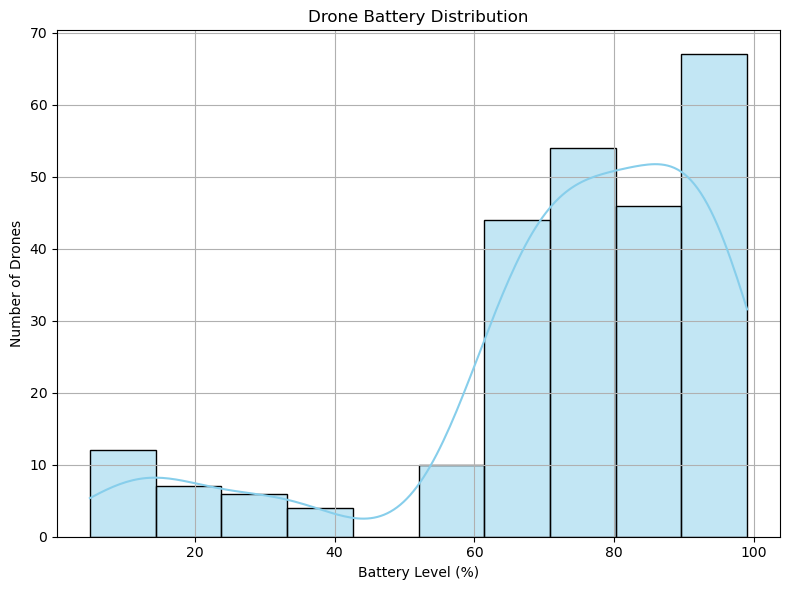

In [85]:
plot_battery_distribution(drones)

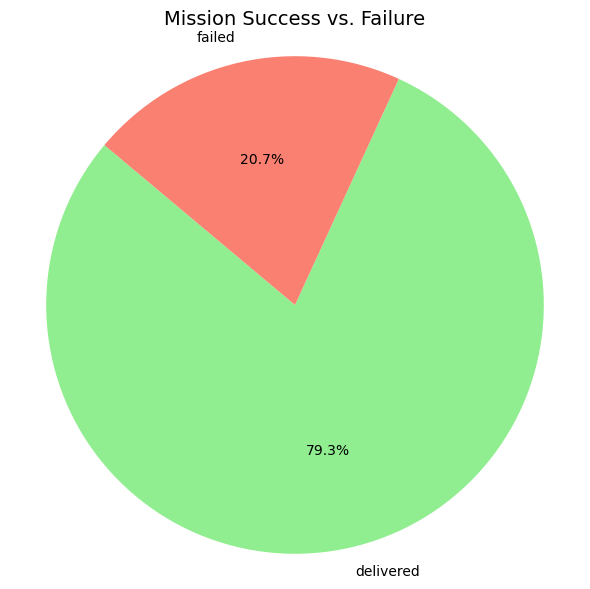

In [86]:
plot_delivery_outcome_pie()

In [87]:
def get_warehouse_color_map(warehouses):
    colors = ['blue', 'green', 'orange', 'purple', 'red']
    return {hub: colors[i % len(colors)] for i, hub in enumerate(warehouses)}

In [88]:
def draw_flight_paths(deliveries, warehouses):
    nyc_center = (40.7549, -73.9840)
    m = folium.Map(location=nyc_center, zoom_start=11, tiles='cartodbpositron')
    color_map = get_warehouse_color_map(warehouses)
    for name, coord in warehouses.items():
        folium.Marker(
            location=coord,
            popup=name,
            icon=folium.Icon(color=color_map[name], icon='home', prefix='fa')
        ).add_to(m)
    for delivery in deliveries:
        hub_name = delivery["assigned_hub"]
        start = warehouses.get(hub_name)
        end = delivery["location"]
        if start and end:
            folium.PolyLine(
                locations=[start, end],
                color=color_map.get(hub_name, "gray"),
                weight=2,
                opacity=0.6,
                tooltip=f"{delivery['delivery_id']} from {hub_name}"
            ).add_to(m)
    return m

In [89]:
flight_map = draw_flight_paths(deliveries, warehouses)

In [90]:
flight_map

In [91]:
def add_failure_reason_column(db_path="nydroneai.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute("ALTER TABLE deliveries ADD COLUMN failure_reason TEXT")
        conn.commit()
        print("Added 'failure_reason' column to 'deliveries' table.")
    except sqlite3.OperationalError as e:
        if "duplicate column" in str(e).lower():
            print("Column already exists.")
        else:
            raise
    conn.close()

In [92]:
add_failure_reason_column()

Column already exists.
